In [1]:
import numpy as np
import math
from scipy.optimize import root,minimize
import itertools
import matplotlib.pyplot as plt
from scipy.stats import rv_continuous, multivariate_normal

In [91]:
def infNorm(vec):
    return(max(abs(np.array(vec))))

def HNorm(vec, H):
    d = len(vec)
    return np.dot(np.dot(np.asarray(vec),np.asarray(H)),np.asarray(vec).reshape(1,d).T)

def _minf(g,ita):
    g = np.asarray(g)
    err = 1e-10
    v = lambda k:(np.dot(np.array(k),sum(g).T)+(1/ita)*sum(np.array(k)*np.log(np.array(k)+err)))
    return v

def _minf_7(g,ita,H):
    g = np.asarray(g)
    err = 1e-10
    v = lambda k:(np.dot(np.array(k),sum(g).T)+(1/ita)*HNorm(k,H))
    return v

def _minf_11(g,ita,H,U):
    g = np.asarray(g)
    err = 1e-10
    v = lambda k:(np.dot(np.array(k),sum(np.dot(g,U.T)).T)+(1/ita)*HNorm(k,H))
    return v

def _argmin(g,N,ita):
    State = False
    err = 1e-10
    xbounds = [(0,1)]*N
    cons = [{'type':'eq','fun': lambda x:(sum(x)-1+err)}]
    #while State ==False:
    x0 = np.asarray(np.random.random(N))
    result = minimize(_minf(g,ita),x0,method='SLSQP',constraints=cons,bounds=xbounds)
        #State = result.success
    #print('\n Optimization Result: ',result.success)
    return (result.x.round(3))

def _argmin_7(g,N,ita,H):
    State = False
    xbounds = [(0,1)]*N
    err = 1e-10
    cons = [{'type':'eq','fun': lambda x:(sum(x)-1+err)}]
    #while State ==False:
    x0 = np.asarray(np.random.random(N))
    result = minimize(_minf_7(g,ita,H),x0,method='SLSQP',constraints=cons,bounds=xbounds)
        #State = result.success
    #print('\n Optimization Result: ',result.success)
    return (result.x.round(3))

def _argmin_11(g,N,ita,H,U):
    State = False
    err = 1e-10
    xbounds = [(0,1)]*N
    cons = [{'type':'eq','fun': lambda x:(sum(x)-1+err)}]
    #while State ==False:
    x0 = np.asarray(np.random.random(N))
    result = minimize(_minf_11(g,ita,H,U),x0,method='SLSQP',constraints=cons,bounds=xbounds)
        #State = result.success
    #print('\n Optimization Result: ',result.success)
    return (result.x.round(3))

def calLt(U,vt):
    arrLt= np.dot(vt,U.T)
    return arrLt/(infNorm(arrLt))

class MNormDist(rv_continuous):
    def _pdf(self,x,M,epsi,d):
        lamd = np.sqrt(np.linalg.det((2/epsi)*M))*np.pi**(d/2)/(math.gamma(d/2+1))
        return np.exp(-epsi/2*x)/(math.gamma(d+1)*lamd)


#### ALGORITHM 6

In [5]:
def Algorithm6(T,M,N,d,U,Gvt,epi = None):
    if epi==None:
        epi = 1/np.sqrt(T)
    lamb = 2/epi
    ita = np.sqrt(np.log(N)/T)
    err = 1e-10

    X = np.ones((T,M,N))/N
    Lt = np.zeros((T,N))
    Rtj = np.zeros((T,M))
    Rt = np.zeros(T)
    #Zt = np.zeros((M,N))
    gtj = np.zeros((M,T,N))

    #np.random.seed(20230301)

    for t in range(T):
        #print('X=',X[t])

        vt = Gvt[t]
        Lt[t] = calLt(U,vt)
        #print('Lt=',Lt[t])

        for j in range(M):
            sumXL = 0
            for k in range(t+1):
                #print(X[k][j])
                sumXL += np.dot(X[k][j],Lt[k].reshape(1,N).T)
                #print(sumXL)
            if t==0:
                Rtj[t][j] = sumXL - min(Lt[t])
                #print(min(Lt[t]))
            else:
                Rtj[t][j] = sumXL - min(sum(Lt[0:t+1]))
                #print(min(sum(Lt[0:t+1])))
        #print('Rtj=',Rtj[t])
        Rt[t] = sum(Rtj[t])/M
        #print('Rt=',Rt[t])
        if t<T-1:
            for iz in range(M):
                Zt = np.random.laplace(0,lamb,N)
                gtj[iz][t] = Lt[t]+Zt
                #print(gtj)
                #print(X[iz])
            #for iz in range(M):
                X[t+1][iz] = _argmin(gtj[iz],N,ita)
                #print('X=',X[t+1][iz])
                #print(t,iz)
                #print('\n')
        else:
            break
        #print('\n')
    return Rt
    

### MVEE

In [7]:
def checkFunc(U,E,d):
    U = np.mat(U)
    E = np.mat(E)
    #print(U,E)
    for i in range(U.shape[0]):
        if 1/(d+1)*np.dot(np.dot(U[i],E),U[i].T) > 1:
            #print(i)
            i_star = i
            alpha = -1/np.sqrt(np.dot(np.dot(U[i_star],E),U[i_star].T))
            alpha = np.array(alpha)[0][0]
            
            if alpha <= -1/np.sqrt(d):
                #print(alpha)
                continue
            else:
                #print(alpha)
                #print(U[i_star].T.shape,E.shape)
                b = -alpha*np.dot(E,U[i_star].T)
                #print(b)
                #print('value of bbT:',np.dot(b,b.T))
                E = (d/(d-1))*(1-alpha**2)*(E-((1-d*alpha**2)/(1-alpha**2))*np.dot(b,b.T))
                #print(E)
                #print('\n')
                checkFunc(U,E,d)
        if i == np.asarray(U).shape[0]-1:
            return E


def MVEE(U):
    U = np.mat(U)
    N,d = U.shape[0],U.shape[1]
    E = np.diag(np.asarray([N]*d))
    if d==1:
        M = (1/infNorm(U))[0]
        print(M)
        return M
    else:
        return checkFunc(U,E,d)
     
        

### Algorithm 7

In [10]:
def Algorithm7(T,M,N,d,U,Gvt,epi=None):
    if epi==None:
        epi = 1/np.sqrt(T)
    ita = np.sqrt(d/T)
    err = 1e-10

    X = np.ones((T,M,N))/N
    Lt = np.zeros((T,N))
    Rtj = np.zeros((T,M))
    Rt = np.zeros(T)
    #Zt = np.zeros((M,N))
    gtj = np.zeros((M,T,N))

    #np.random.seed(202303)
    MU = MVEE(U)
    Zt = ARSampling(MU,epi,d,M*T)
    Zt = Zt.reshape(T,M,d)

    for t in range(T):
        vt = Gvt[t]
        Lt[t] = calLt(U,vt)
        #print(Lt[t])

        for j in range(M):
            sumXL = 0
            for k in range(t+1):
                #print(X[k][j])
                sumXL += np.dot(X[k][j],Lt[k].reshape(1,N).T)
                #print(sumXL)
            if t==0:
                Rtj[t][j] = sumXL - min(Lt[t])
                #print(min(Lt[t]))
            else:
                Rtj[t][j] = sumXL - min(sum(Lt[:t+1]))
                #print(min(sum(Lt[0:t+1])))
        #print(Rtj[t])
        Rt[t] = sum(Rtj[t])/M

        H = np.eye(N)+np.dot(np.dot(U,MU),U.T)
        if t<T-1:
            for iz in range(M):
                gtj[iz][t] = Lt[t]+np.dot(U,Zt[t][iz])
                #print(gtj)
                #print(X[iz])
            #for iz in range(M):
                X[t+1][iz] = _argmin_7(gtj[iz],N,ita,H)
                #print(X[t+1][iz])
        else:
            break
        #print('\n')
    return Rt


In [167]:
T = 2**10
M = 10
N = 20
N2 = 20
d = 3
U = np.zeros((N,d))
U2 = np.zeros((N2,d))
#np.random.seed(23032702)
while np.linalg.matrix_rank(U) !=d:
    for iN in range(N):
        U[iN] = np.random.uniform(-1,1,d)
        
while np.linalg.matrix_rank(U2) !=d:
    for iN in range(N2):
        U2[iN] = np.random.uniform(-1,1,d)

In [43]:
vt = np.random.uniform(-1,1,d)
Lt[3] = calLt(U,vt)
print(U)
print(np.dot(U,vt))
print(vt,Lt[:4])

[[-0.93045356 -0.46752447]
 [ 0.84317983 -0.29901021]
 [ 0.83112029  0.97376589]
 [-0.41431578  0.22993205]
 [ 0.31074277 -0.04818896]
 [-0.62377862 -0.38300013]
 [-0.07536569  0.90151247]
 [-0.00871288  0.37555592]
 [-0.35653569 -0.15463729]
 [-0.97041292 -0.9794157 ]]
[ 0.2682098  -0.63484685  0.06193619  0.35694766 -0.20034783  0.14209173
  0.53100008  0.20848856  0.11606229  0.01309738]
[-0.56066536  0.54213909] [[-0.44970405  1.         -0.05425677 -0.55942422  0.31770131 -0.24444688
  -0.80655886 -0.31569238 -0.19241462 -0.065814  ]
 [ 0.28016294 -1.          0.32393346  0.57707099 -0.30451887  0.11599572
   0.99253404  0.39487683  0.13265996 -0.21556521]
 [ 0.57472568 -1.         -0.14460603  0.54641128 -0.3274222   0.33916828
   0.66941855  0.25730083  0.23647842  0.27330638]
 [ 0.42247953 -1.          0.09756084  0.5622579  -0.31558451  0.22382048
   0.83642233  0.32840764  0.18281935  0.02063077]]


In [32]:
X = np.ones((T,M,N))/N

In [48]:
sum(Lt[0:3])

array([ 0.40518457, -1.        ,  0.12507067,  0.56405805, -0.31423976,
        0.21071713,  0.85539373,  0.33648528,  0.17672376, -0.00807284])

In [30]:
U

array([[ 0.85283787,  0.43109899],
       [-0.06053427, -0.51599741]])

In [31]:
MVEE(U)

matrix([[2, 0],
        [0, 2]])

In [71]:
Gvt = np.random.uniform(-1,1,(T,d))
Rt_7 = Algorithm7(T,M,N,d,U,Gvt,epi=1)
Rt_6 = Algorithm6(T,M,N,d,U,Gvt,epi=1)

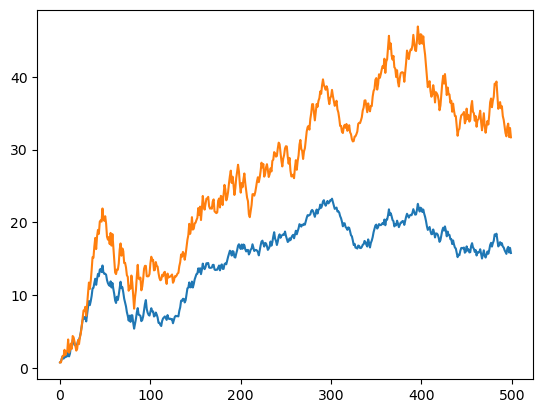

In [75]:
plt.plot(Rt_6)
plt.plot(Rt_7)

In [168]:
Gvt1 = np.random.uniform(-1,1,(T,d))
Gvt2 = np.random.uniform(-1,1,(T,d))
for iepi in [1,0.5,0.1,0.05,0.01]:
    Rt_6 = Algorithm6(T,M,N,d,U,Gvt1,epi=iepi)
    print(r'Algorithm 6 done! \n')
    Rt_7 = Algorithm7(T,M,N,d,U,Gvt1,epi=iepi)
    print(r'Algorithm 7 done! \n')
    np.savetxt(r'Regrets of Alg6,Alg7 vs Time (Total Time = 1024, M=10,N=20,d=3,epsilon = %0.3f)v1.txt'%iepi,[Rt_6,Rt_7])
    
    Rt_9 = Algorithm9(T,M,N2,d,U2,Gvt2,epi=iepi)
    print(r'Algorithm 9 done! \n')
    Rt_11 = Algorithm11(T,M,N2,d,U2,Gvt2,epi=iepi)
    print(r'Algorithm 11 done! \n')
    np.savetxt(r'Regrets of Alg9,Alg11 vs Time (Total Time = 1024, M=10,N=20,d=3,epsilon = %0.3f)v1.txt'%iepi,[Rt_9,Rt_11])

Algorithm 6 done! \n
Algorithm 7 done! \n
Algorithm 9 done! \n
Algorithm 11 done! \n
Algorithm 6 done! \n
Algorithm 7 done! \n
Algorithm 9 done! \n
Algorithm 11 done! \n
Algorithm 6 done! \n
Algorithm 7 done! \n
Algorithm 9 done! \n
Algorithm 11 done! \n
Algorithm 6 done! \n
Algorithm 7 done! \n
Algorithm 9 done! \n
Algorithm 11 done! \n
Algorithm 6 done! \n
Algorithm 7 done! \n
Algorithm 9 done! \n
Algorithm 11 done! \n


In [288]:
for iepi in [1,0.1,0.01]:
    Rt_9 = Algorithm9(T,M,N,d,U,epi=iepi)
   
    Rt_11 = Algorithm11(T,M,N,d,U,epi=iepi)

Algorithm 9 done! \n
Algorithm 11 done! \n
Algorithm 9 done! \n
Algorithm 11 done! \n
Algorithm 9 done! \n
Algorithm 11 done! \n


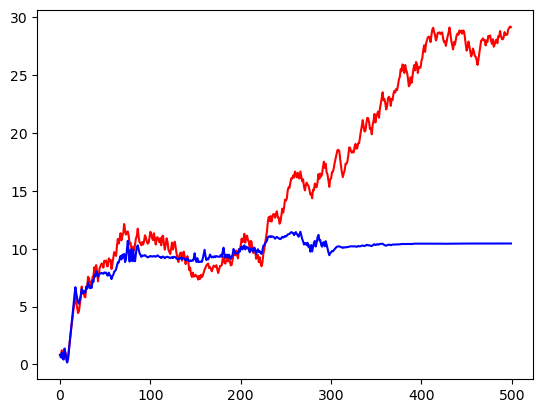

In [54]:
xt = range(500)
plt.plot(Rt_6,'r-')
plt.plot(Rt_7,'b-')

In [164]:
#Rt_9, Rt_11 = np.loadtxt(r'Regrets of Alg9,Alg11 vs Time (Total Time = 1024, M=20,N=30,d=3,epsilon = 0.100)v1.txt')
Rt_6, Rt_7 = np.loadtxt(r'Regrets of Alg6,Alg7 vs Time (Total Time = 1000, M=20,N=50,d=2,epsilon = 1.000).txt')


<function matplotlib.pyplot.show(close=None, block=None)>

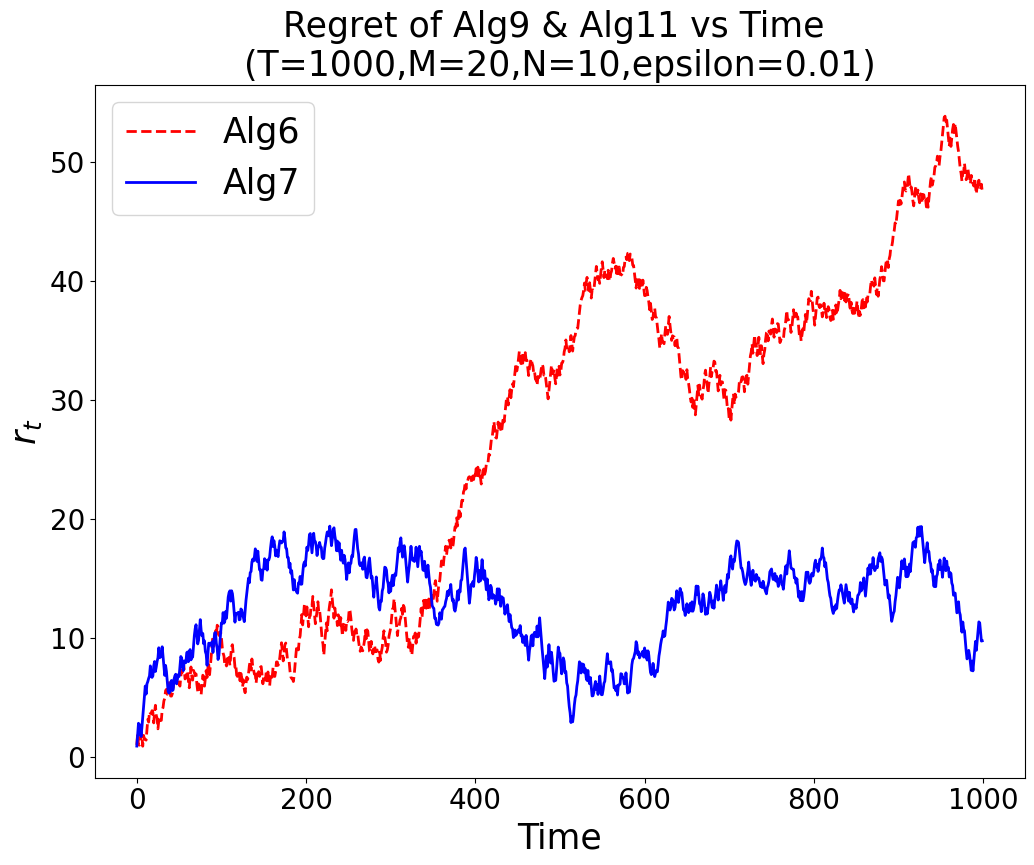

In [165]:
xt = range(1000)
plt.figure(figsize= (12,9))
#plt.plot(xt,Rt_9,'r--',label = 'Alg9',linewidth=2, markersize=7)
#plt.plot(xt,Rt_11,'b-',label = 'Alg11',linewidth=2, markersize=7)
plt.plot(xt,Rt_6,'r--',label = 'Alg6',linewidth=2, markersize=7)
plt.plot(xt,Rt_7,'b-',label = 'Alg7',linewidth=2, markersize=7)
plt.xlabel('Time',fontsize = 25)
plt.ylabel(r'$r_t$',fontsize = 25)
plt.title('Regret of Alg9 & Alg11 vs Time \n(T=1000,M=20,N=10,epsilon=0.01)',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=25)
plt.show
#plt.savefig(r'Regrets of Alg9,Alg11 vs Time (T=1000,M=20,N=10,epsilon=0.01)v1.png',dpi=500)

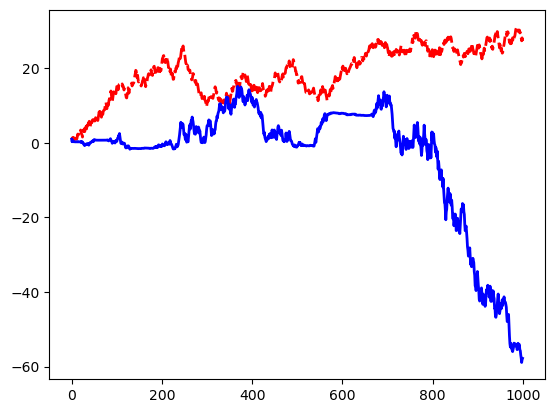

In [22]:
plt.plot(xt,Rt_6,'r--',label = 'Alg6',linewidth=2, markersize=7)
plt.plot(xt,Rt_7,'b-',label = 'Alg7',linewidth=2, markersize=7)

In [34]:
Zt = ARSampling(MU,epi,d,M*T)
Zt = Zt.reshape(T,M,d)

In [36]:
Zt[0]

array([[ 12.87657621, -62.99072139],
       [ 12.71954567, -62.78893183],
       [ 12.62365132, -63.02128015],
       [ 12.58421701, -62.843739  ],
       [ 12.67241143, -62.53364459],
       [ 12.90078341, -62.47377883],
       [ 12.06727098, -62.26393011],
       [ 12.48596827, -62.49635841],
       [ 12.65026286, -62.30700266],
       [ 12.73430406, -62.21824926]])

In [46]:
np.eye(2)+np.asarray(E)

array([[ 5., -3.],
       [-3.,  5.]])

In [31]:
U = np.ones((4,3))

E = MVEE(U)
print(E)
#for i in range(np.asarray(U).shape[0]):
#    print(1/(3+1)*np.dot(np.dot(U[i],E),U[i].reshape((1,1)).T))

[[ 4.  -1.5 -1.5]
 [-1.5  4.  -1.5]
 [-1.5 -1.5  4. ]]


In [86]:
a = np.mat(np.array([1,2]))
b = np.mat(np.ones((2,2)))
c = a@b[1].T


matrix([[3.]])

In [35]:
def ARSampling(M,epsi,d,n):
    xt = np.zeros(d)
    cov = M*2/epsi
    BurnSize = 10000
    samples = []
    for i in range(BurnSize+n):
        xt_candidate = np.random.multivariate_normal(xt,cov)
        #multivariate_normal.pdf(xt_candidate,mean=xt,cov=cov)
        prob_accept = MHNFunc(xt_candidate,M,epsi,d)/MHNFunc(xt,M,epsi,d)
        if np.random.uniform(0,1) <min(prob_accept,1):
            xt = xt_candidate
        samples.append(xt)
    return np.asarray(samples[BurnSize:])

    
def MHNFunc_test(x,X,k,M,epsi,d):
    X[k]=x
    if d ==1 :
        lamd = (2/epsi)*M*np.pi**(d/2)/(math.gamma(d/2+1))
    else:
        lamd = np.sqrt(np.linalg.det((2/epsi)*M))*np.pi**(d/2)/(math.gamma(d/2+1))
    return np.exp((-epsi/2)*np.sqrt(HNorm(np.asarray(X),np.linalg.inv(M))[0]))/(math.gamma(d+1)*lamd)

def MHNFunc(x,M,epsi,d):
    if d ==1 :
        lamd = (2/epsi)*M*np.pi**(d/2)/(math.gamma(d/2+1))
    else:
        lamd = np.sqrt(np.linalg.det((2/epsi)*M))*np.pi**(d/2)/(math.gamma(d/2+1))
    return np.exp((-epsi/2)*np.sqrt(HNorm(np.asarray(x),np.linalg.inv(M))[0]))/(math.gamma(d+1)*lamd)




In [47]:
d = 3
xt = np.zeros(d)
cov = np.ones((3,3))
xt_candidate = np.random.multivariate_normal(xt,cov,size = 3)
np.
E,cov, xt_candidate

(matrix([[ 4. , -1.5, -1.5],
         [-1.5,  4. , -1.5],
         [-1.5, -1.5,  4. ]]),
 array([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]),
 array([[0.65539479, 0.65539481, 0.65539481],
        [0.39807565, 0.39807566, 0.39807566],
        [1.02562152, 1.02562151, 1.02562151]]))

In [38]:
E = np.asarray([[2,-1],[-1,2]])
x3 = []
x3=(ARSampling(E,epsi=1,d=2,n=100000))

In [127]:
x3[:10]

array([[ 12.0140968 ,  -8.11193422],
       [ 12.0140968 ,  -8.11193422],
       [ 12.05623507,  -6.97891038],
       [ 12.05623507,  -6.97891038],
       [ 12.05623507,  -6.97891038],
       [ 12.05623507,  -6.97891038],
       [ 13.11564871,  -4.78463264],
       [ 13.31134611,  -1.59036868],
       [  2.33769303, -14.23648098],
       [  5.39735613, -11.69059995]])

In [136]:
y4=[]
for xi in np.asarray(x3).T[0]:
    y4.append(MHNFunc_test(xi,X,1,E,1,2))

In [131]:
n=2
xt = np.zeros(n)
cov = np.linalg.inv(E)
np.random.multivariate_normal(xt,cov,size = 1)

array([[-0.46975734,  0.58557761]])

In [32]:
E = np.asarray([[2,-1],[-1,2]])
x = np.linspace(-50,50,num=500)
#y = np.linspace(-10,10)
y = []
for xi in x:
    y.append(MHNFunc_test(xi,X,1,E,1,2))
y[49]


NameError: name 'X' is not defined

In [34]:
x2 = np.linspace(-50,50,num=200)
y2 = 1/np.sqrt(2*np.pi*90)*np.exp(-x2**2/(2*90))

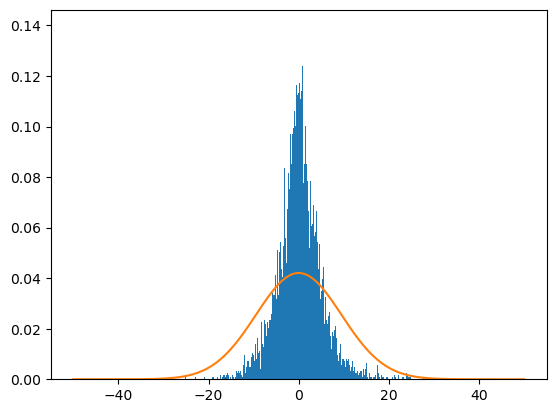

In [39]:
#plt.plot(x,y)
#plt.scatter(np.asarray(x3).T[0],y4)
plt.hist(np.asarray(x3).T[0],density=True,bins=5000)
plt.plot(x2,y2)

In [68]:
y[10],y2[10]

(array([1.73696613e-10]), 1.6165436295351197e-06)

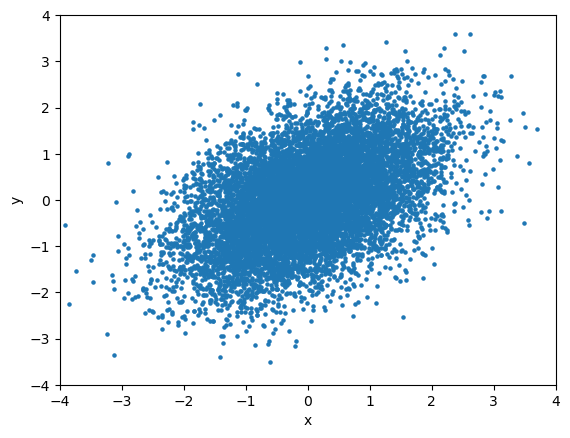

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Define the target distribution as a bivariate Gaussian
mean = np.array([0, 0])
cov = np.array([[1, 0.5], [0.5, 1]])

# Define the conditional distributions
def cond_dist_x(y):
    return np.random.normal(mean[0] + cov[0, 1] * (y - mean[1]) / cov[1, 1], np.sqrt(1 - cov[0, 1]**2))

def cond_dist_y(x):
    return np.random.normal(mean[1] + cov[1, 0] * (x - mean[0]) / cov[0, 0], np.sqrt(1 - cov[1, 0]**2))

# Set the number of samples and burn-in period
n_samples = 10000
burn_in = 1000

# Initialize the algorithm
x = 0
y = 0
samples = np.zeros((n_samples, 2))

# Run the algorithm
for i in range(n_samples + burn_in):
    x = cond_dist_x(y)
    y = cond_dist_y(x)
    if i >= burn_in:
        samples[i - burn_in] = [x, y]

# Plot the results
plt.scatter(samples[:, 0], samples[:, 1], s=5)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


### Algorithm 9

In [13]:
def Algorithm9(T,M,N,d,U,Gvt,epi = None):
    if epi==None:
        epi = 1/np.sqrt(T)
    lamb = np.log2(T)/epi
    ita = np.sqrt(np.log(N)/T)
    err = 1e-10

    X = np.zeros((T,M,N))/N
    X[0] = np.ones((M,N))/N
    Lt = np.zeros((T,N))
    Rtj = np.zeros((T,M))
    Rt = np.zeros(T)
    n_len = int(np.log2(T))
    nLap = np.random.laplace(0,lamb,size=(n_len,N))
    V = np.zeros((M,T,N))

    #np.random.seed(202303019)

    for t in range(T):
        #print(X[t])

        vt = Gvt[t]
        Lt[t] = calLt(U,vt)
        #print('Lt = ',Lt[t])

        for j in range(M):
            sumXL = 0
            for k in range(t+1):
                #print(X[k][j])
                sumXL += np.dot(X[k][j],Lt[k].reshape(1,N).T)
                #print('sumXL = ',sumXL)
            if t==0:
                Rtj[t][j] = sumXL - min(Lt[t])
                #print(min(Lt[t]))
            else:
                Rtj[t][j] = sumXL - min(sum(Lt[:t+1]))
                #print('min of Lt = ',min(sum(Lt[:t+1])))
        #print(Rtj[t])
        Rt[t] = sum(Rtj[t])/M
        if t<T-1:
            TLt = sum(Lt[:t+1])
            st = calSt(t)
            for iz in range(M):
                epsi_t = np.random.laplace(0,lamb,size=(st,N))
                V[iz][t] = sum(epsi_t) + TLt + sum(nLap[:n_len-st])
                #print(gtj)
                #print(X[iz])
            #for iz in range(M):
                X[t+1][iz] = _argmin(V[iz],N,ita)
                #print(X[t+1][iz])
        else:
            break
        #print('\n')
    return Rt

def TreeAgg(lt,T,epsi):
    n_len = np.log2(T)
    lambd = n_len/epsi
    n = np.random.laplace(0,lambd,size=n_len)
    V = np.zeros(T)
    for t in range(T):
        Lt = sum(lt[:t])
        st = calSt(t)
        epsi_t = np.random.laplace(0,lambd,size=st)
        V[t] = sum(epsi_t) + Lt + sum(n[:n_len-st])
    return V

In [212]:
T = 2**8
M = 5
N = 5
d = 2
U = np.zeros((N,d))

while np.linalg.matrix_rank(U) !=d:
    for iN in range(N):
        U[iN] = np.random.uniform(-1,1,d)
        
Gvt2 = np.random.uniform(-1,1,(T,d))
Rt_9_1 = Algorithm9(T,M,N,d,U,Gvt2)

Lt =  [-0.60461337  0.55989415 -0.11755318  0.79927017 -1.        ]
sumXl =  [-0.07260045]
sumXl =  [-0.07260045]
sumXl =  [-0.07260045]
sumXl =  [-0.07260045]
sumXl =  [-0.07260045]
[9.99839460e-01 1.01257825e-12 1.60543253e-04 8.84352206e-13
 2.48107934e-13]
[9.99999999e-01 0.00000000e+00 0.00000000e+00 9.20072605e-09
 7.57769837e-09]
[9.99933282e-01 5.66456769e-09 1.29306017e-05 1.16999136e-08
 5.37700025e-05]
[9.99999950e-01 1.04577980e-08 2.92512991e-08 1.49303073e-08
 7.04048691e-09]
[1.90340619e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00]
Lt =  [ 0.43735185 -0.12022166  0.09550632 -1.          0.50632425]
sumXl =  [0.36469652]
min of Lt =  -0.4936757469711992
sumXl =  [0.3647514]
min of Lt =  -0.4936757469711992
sumXl =  [0.36475067]
min of Lt =  -0.4936757469711992
sumXl =  [0.36475137]
min of Lt =  -0.4936757469711992
sumXl =  [0.43372382]
min of Lt =  -0.4936757469711992
[9.99999807e-01 0.00000000e+00 2.09651169e-07 0.00000000e+00
 4.77866042e-14]
[1.0000

[1.00000000e+00 0.00000000e+00 2.20294672e-05 0.00000000e+00
 0.00000000e+00]
[1. 0. 0. 0. 0.]
[1.07233800e-05 0.00000000e+00 1.00000000e+00 0.00000000e+00
 3.12329313e-15]
Lt =  [-0.52089769  0.66405358 -0.09459491  0.41947865 -1.        ]
sumXl =  [3.23865062]
min of Lt =  -7.457964247109467
sumXl =  [3.2386797]
min of Lt =  -7.457964247109467
sumXl =  [2.78267227]
min of Lt =  -7.457964247109467
sumXl =  [3.23870321]
min of Lt =  -7.457964247109467
sumXl =  [2.69042824]
min of Lt =  -7.457964247109467
[1.00000000e+00 0.00000000e+00 1.41564655e-05 0.00000000e+00
 0.00000000e+00]
[1.00000000e+00 0.00000000e+00 3.75917086e-10 0.00000000e+00
 0.00000000e+00]
[9.99999650e-01 3.21039051e-07 0.00000000e+00 5.63482991e-08
 2.14738102e-07]
[1.00000000e+00 0.00000000e+00 1.31830141e-05 0.00000000e+00
 0.00000000e+00]
[3.50421236e-08 4.01420251e-08 9.99999943e-01 2.52711136e-08
 0.00000000e+00]
Lt =  [ 0.61756311 -0.54378202  0.12110453 -0.85801904  1.        ]
sumXl =  [3.85621544]
min of Lt 

[0.0000000e+00 0.0000000e+00 1.0000000e+00 1.7384608e-13 9.3832664e-08]
[1.00000000e+00 0.00000000e+00 8.02815982e-06 1.21312767e-13
 0.00000000e+00]
[9.99983990e-01 5.52239617e-07 1.32538504e-05 0.00000000e+00
 2.92411596e-06]
[9.38498278e-14 3.97259267e-06 9.99995542e-01 2.96688601e-06
 2.34510431e-06]
Lt =  [-0.39620112  0.81920165 -0.06039801 -0.14623025 -1.        ]
sumXl =  [6.00014599]
min of Lt =  -10.266003715563613
sumXl =  [5.99461037]
min of Lt =  -10.266003715563613
sumXl =  [5.35344739]
min of Lt =  -10.266003715563613
sumXl =  [5.80947498]
min of Lt =  -10.266003715563613
sumXl =  [3.17565641]
min of Lt =  -10.266003715563613
[1.403057e-04 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00]
[0. 0. 1. 0. 0.]
[1.00000000e+00 0.00000000e+00 8.80564295e-07 6.84991019e-16
 0.00000000e+00]
[9.99995782e-01 3.33530978e-06 3.54607990e-07 1.55317831e-06
 0.00000000e+00]
[1.75291829e-05 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00677116e-10]
Lt =  [ 0.57488282 -0.3703186   0

[0.00000000e+00 0.00000000e+00 9.99956491e-01 4.54118847e-05
 5.57361284e-05]
[2.87597978e-05 1.34125447e-15 9.99999207e-01 6.43848517e-16
 0.00000000e+00]
[0. 0. 1. 0. 0.]
Lt =  [-0.25241572 -0.21608047 -0.0656195   1.         -0.07466817]
sumXl =  [5.83434795]
min of Lt =  -6.6841459179718
sumXl =  [5.99599913]
min of Lt =  -6.6841459179718
sumXl =  [5.64365834]
min of Lt =  -6.6841459179718
sumXl =  [6.37237651]
min of Lt =  -6.6841459179718
sumXl =  [3.0094516]
min of Lt =  -6.6841459179718
[5.70975964e-07 5.49784735e-05 9.99845406e-01 3.53967781e-05
 1.25327372e-04]
[6.56224530e-09 0.00000000e+00 9.99998820e-01 1.18422112e-06
 4.24087590e-07]
[5.62942712e-05 0.00000000e+00 1.00000000e+00 6.63139484e-06
 0.00000000e+00]
[0.00000000e+00 6.07972004e-05 9.99751800e-01 9.38661834e-05
 3.30570020e-04]
[8.14755084e-05 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00]
Lt =  [-0.61946002  0.45138121 -0.12493612  1.         -0.93137966]
sumXl =  [5.70937427]
min of Lt =  -6.2327

Lt =  [-0.43030163  0.77677363 -0.06974976  0.00847298 -1.        ]
sumXl =  [5.65112463]
min of Lt =  -5.314289787951306
sumXl =  [5.81318947]
min of Lt =  -5.314289787951306
sumXl =  [5.46114741]
min of Lt =  -5.314289787951306
sumXl =  [6.18964561]
min of Lt =  -5.314289787951306
sumXl =  [2.82665111]
min of Lt =  -5.314289787951306
[1.16674258e-04 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00]
[6.54758883e-05 5.06746328e-13 1.00000000e+00 5.21610124e-05
 0.00000000e+00]
[5.86902831e-07 0.00000000e+00 1.00000000e+00 1.33247224e-06
 0.00000000e+00]
[4.30203865e-09 1.69319909e-05 1.00000000e+00 0.00000000e+00
 0.00000000e+00]
[4.52459111e-04 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00]
Lt =  [-0.17537336 -0.35618024 -0.05316898  1.          0.10515502]
sumXl =  [5.59793519]
min of Lt =  -5.670470026494389
sumXl =  [5.76006117]
min of Lt =  -5.670470026494389
sumXl =  [5.40797966]
min of Lt =  -5.670470026494389
sumXl =  [6.13647061]
min of Lt =  -5.6704

[4.02743725e-06 9.67160880e-06 9.99998101e-01 3.74671522e-06
 0.00000000e+00]
[0.00000000e+00 7.41889009e-06 9.99989675e-01 0.00000000e+00
 6.40091616e-06]
[1.39692667e-04 0.00000000e+00 1.00000000e+00 1.77104096e-11
 0.00000000e+00]
Lt =  [-0.52370223  0.66056416 -0.09536403  0.43220196 -1.        ]
sumXl =  [5.6308778]
min of Lt =  -5.56323895746104
sumXl =  [5.79325018]
min of Lt =  -5.56323895746104
sumXl =  [5.44117482]
min of Lt =  -5.56323895746104
sumXl =  [6.16882378]
min of Lt =  -5.56323895746104
sumXl =  [2.8059149]
min of Lt =  -5.56323895746104
[0. 0. 1. 0. 0.]
[2.3038582e-04 0.0000000e+00 1.0000000e+00 1.7683030e-04 0.0000000e+00]
[6.41333083e-04 0.00000000e+00 1.00000000e+00 2.83501276e-04
 0.00000000e+00]
[0.00000000e+00 0.00000000e+00 9.99961629e-01 1.49915558e-05
 4.92020940e-05]
[0.00000000e+00 0.00000000e+00 1.00000000e+00 9.42955430e-09
 2.07435528e-06]
Lt =  [-0.59661649  0.5698439  -0.11536011  0.76299087 -1.        ]
sumXl =  [5.51551769]
min of Lt =  -4.800248

sumXl =  [5.93907395]
min of Lt =  -6.545960552513108
sumXl =  [6.10116877]
min of Lt =  -6.545960552513108
sumXl =  [5.74940124]
min of Lt =  -6.545960552513108
sumXl =  [6.4726374]
min of Lt =  -6.545960552513108
sumXl =  [3.12308842]
min of Lt =  -6.545960552513108
[0. 0. 1. 0. 0.]
[0.00000000e+00 0.00000000e+00 1.00000000e+00 2.66707255e-04
 0.00000000e+00]
[0.00000000e+00 0.00000000e+00 1.00000000e+00 3.65317119e-04
 0.00000000e+00]
[1.51520631e-05 2.26331326e-05 1.00000000e+00 0.00000000e+00
 0.00000000e+00]
[8.1592117e-06 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
Lt =  [-0.23127583 -0.25452287 -0.06220316  1.         -0.02532593]
sumXl =  [5.87687078]
min of Lt =  -6.800483422619093
sumXl =  [6.03923232]
min of Lt =  -6.800483422619093
sumXl =  [5.6875634]
min of Lt =  -6.800483422619093
sumXl =  [6.41042497]
min of Lt =  -6.800483422619093
sumXl =  [3.06088337]
min of Lt =  -6.800483422619093
[0. 0. 1. 0. 0.]
[5.84887377e-08 0.00000000e+00 1.00000000e+00 2.435807

[1.14749104e-05 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00]
[0.00156882 0.         1.         0.         0.        ]
Lt =  [ 0.17375805 -0.99106772  0.00325281  1.          0.92005633]
sumXl =  [6.44843779]
min of Lt =  -10.318064111906818
sumXl =  [6.60798311]
min of Lt =  -10.318064111906818
sumXl =  [6.2676717]
min of Lt =  -10.318064111906818
sumXl =  [6.98838683]
min of Lt =  -10.318064111906818
sumXl =  [3.63582881]
min of Lt =  -10.318064111906818
[0.00000000e+00 1.56470203e-03 1.00000000e+00 1.26243259e-05
 0.00000000e+00]
[0.         0.         1.         0.00138042 0.        ]
[1.90440430e-12 7.63034776e-05 1.00000000e+00 3.42333615e-04
 0.00000000e+00]
[3.76327535e-07 6.65060293e-08 1.00000000e+00 0.00000000e+00
 0.00000000e+00]
[0.0000000e+00 0.0000000e+00 1.0000000e+00 3.1741853e-04 0.0000000e+00]
Lt =  [ 0.19577577  0.31907893  0.05646613 -1.         -0.05753413]
sumXl =  [6.50539056]
min of Lt =  -9.99898518454168
sumXl =  [6.66306883]
min of Lt =  -9.9

[0.00000000e+00 6.41273201e-04 1.00000000e+00 0.00000000e+00
 0.00000000e+00]
[0.00000000e+00 0.00000000e+00 1.00000000e+00 1.76650687e-10
 0.00000000e+00]
[2.91426444e-04 0.00000000e+00 9.99425012e-01 0.00000000e+00
 6.55773953e-04]
[3.95343309e-05 4.23285279e-03 1.00000000e+00 0.00000000e+00
 0.00000000e+00]
[0.0000000e+00 0.0000000e+00 1.0000000e+00 9.6780325e-05 0.0000000e+00]
Lt =  [ 0.27766227  0.17017019  0.0696995  -1.          0.13359569]
sumXl =  [6.74632887]
min of Lt =  -11.058359524736755
sumXl =  [6.89933681]
min of Lt =  -11.058359524736755
sumXl =  [6.54591911]
min of Lt =  -11.058359524736755
sumXl =  [7.25482533]
min of Lt =  -11.058359524736755
sumXl =  [3.90965242]
min of Lt =  -11.058359524736755
[0.00000000e+00 1.66419082e-03 1.00000000e+00 2.88479600e-04
 0.00000000e+00]
[0.00000000e+00 0.00000000e+00 1.00000000e+00 6.22875799e-04
 0.00000000e+00]
[0.00000000e+00 1.65519804e-04 1.00000000e+00 5.34144296e-04
 0.00000000e+00]
[0.00000000e+00 6.38804795e-04 1.000000

[0.         0.         1.         0.00132474 0.        ]
Lt =  [-0.55240678  0.62484983 -0.103236    0.5624254  -1.        ]
sumXl =  [6.07342083]
min of Lt =  -7.986085084453061
sumXl =  [6.25749594]
min of Lt =  -7.986085084453061
sumXl =  [5.94797458]
min of Lt =  -7.986085084453061
sumXl =  [6.59374622]
min of Lt =  -7.986085084453061
sumXl =  [3.26941169]
min of Lt =  -7.986085084453061
[0.         0.01194688 1.         0.         0.        ]
[2.10234620e-08 0.00000000e+00 9.99943322e-01 1.28887609e-04
 0.00000000e+00]
[0.00355608 0.         0.99154523 0.         0.01033916]
[0.00178965 0.         0.99329124 0.         0.00899769]
[5.63202897e-08 0.00000000e+00 1.00000000e+00 1.09709246e-02
 0.00000000e+00]
Lt =  [-0.03831511  0.74476783  0.0186356  -1.         -0.60392141]
sumXl =  [6.10095409]
min of Lt =  -8.98608508445306
sumXl =  [6.2760016]
min of Lt =  -8.98608508445306
sumXl =  [5.96007232]
min of Lt =  -8.98608508445306
sumXl =  [6.60675433]
min of Lt =  -8.98608508445306

[0.00104099 0.         0.99457249 0.         0.00746755]
[2.71302154e-05 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00]
[1.26393244e-09 1.68253953e-03 1.00000000e+00 3.24654042e-04
 0.00000000e+00]
[0.00000000e+00 0.00000000e+00 1.00000000e+00 5.56144085e-04
 0.00000000e+00]
Lt =  [-0.3014326  -0.12694439 -0.07354093  1.         -0.18907758]
sumXl =  [6.37526078]
min of Lt =  -8.795501970636643
sumXl =  [6.56501417]
min of Lt =  -8.795501970636643
sumXl =  [6.24162245]
min of Lt =  -8.795501970636643
sumXl =  [6.8814886]
min of Lt =  -8.795501970636643
sumXl =  [3.56748379]
min of Lt =  -8.795501970636643
[0.00000000e+00 7.53061785e-07 1.00000000e+00 1.11866814e-04
 0.00000000e+00]
[0. 0. 1. 0. 0.]
[0.         0.00459463 1.         0.00476578 0.        ]
[0.         0.00644219 1.         0.00126329 0.        ]
[0.00000000e+00 1.94984176e-10 1.00000000e+00 0.00000000e+00
 0.00000000e+00]
Lt =  [-0.43060023  0.77640211 -0.06983165  0.00982763 -1.        ]
sumXl =  [6.30543

[3.84475546e-14 2.38169770e-06 9.99871084e-01 2.57942582e-04
 0.00000000e+00]
[7.48626600e-03 2.23270581e-07 9.84133770e-01 2.48470300e-05
 2.07272462e-02]
[7.42841010e-05 1.95311853e-05 9.99675944e-01 0.00000000e+00
 3.16136315e-04]
Lt =  [ 0.57266873 -0.59963981  0.10879265 -0.65434747  1.        ]
sumXl =  [6.23061635]
min of Lt =  -8.709941583481987
sumXl =  [6.44425845]
min of Lt =  -8.709941583481987
sumXl =  [6.09754516]
min of Lt =  -8.709941583481987
sumXl =  [6.73748738]
min of Lt =  -8.709941583481987
sumXl =  [3.41783937]
min of Lt =  -8.709941583481987
[6.78097473e-04 3.69226527e-04 1.00000000e+00 0.00000000e+00
 0.00000000e+00]
[4.13862310e-04 0.00000000e+00 1.00000000e+00 4.42647646e-05
 0.00000000e+00]
[0.00000000e+00 7.55383973e-04 1.00000000e+00 1.66091666e-03
 0.00000000e+00]
[0.00000000e+00 1.23176305e-03 1.00000000e+00 3.19996388e-04
 0.00000000e+00]
[0.         0.         1.         0.15470486 0.        ]
Lt =  [ 0.5635907  -0.61093474  0.10630309 -0.61316333  1. 

[0.00000000e+00 1.05992529e-08 1.00000000e+00 1.11443424e-03
 0.00000000e+00]
Lt =  [-0.64052292  0.51521531 -0.12740105  0.96218045 -1.        ]
sumXl =  [6.32854112]
min of Lt =  -8.14380062127613
sumXl =  [6.59893111]
min of Lt =  -8.14380062127613
sumXl =  [6.11195942]
min of Lt =  -8.14380062127613
sumXl =  [6.74434019]
min of Lt =  -8.14380062127613
sumXl =  [3.38348681]
min of Lt =  -8.14380062127613
[0.         0.0124066  1.         0.00663715 0.        ]
[0.00000000e+00 7.47529129e-05 1.00000000e+00 2.11829949e-04
 0.00000000e+00]
[0.00000000e+00 1.18950464e-06 1.00000000e+00 1.48911075e-04
 0.00000000e+00]
[9.09457599e-14 3.60437706e-06 9.99987922e-01 3.91664925e-05
 4.75060625e-05]
[1.15287831e-09 3.41079699e-09 1.00000000e+00 4.15517641e-03
 0.00000000e+00]
Lt =  [-0.37058825  0.85106929 -0.05337391 -0.2624277  -1.        ]
sumXl =  [6.28398431]
min of Lt =  -8.059035214863627
sumXl =  [6.54556523]
min of Lt =  -8.059035214863627
sumXl =  [6.05854744]
min of Lt =  -8.059035

[0.         0.00251575 1.         0.         0.        ]
[0.02488434 0.         0.95455987 0.         0.05872231]
[0.         0.00747004 1.         0.0017843  0.        ]
[2.42074057e-04 0.00000000e+00 9.99295711e-01 0.00000000e+00
 6.90282850e-04]
Lt =  [ 0.5417827  -0.63806836  0.10032244 -0.51422733  1.        ]
sumXl =  [6.71912082]
min of Lt =  -12.266916035633022
sumXl =  [7.04659699]
min of Lt =  -12.266916035633022
sumXl =  [6.72764253]
min of Lt =  -12.266916035633022
sumXl =  [7.35426024]
min of Lt =  -12.266916035633022
sumXl =  [3.88427985]
min of Lt =  -12.266916035633022
[0.00000000e+00 2.83487509e-09 1.00000000e+00 6.98458679e-10
 0.00000000e+00]
[0.00725966 0.         0.9790986  0.         0.02990621]
[0.         0.00821712 1.         0.0176442  0.        ]
[3.90441446e-11 5.86072624e-03 1.00000000e+00 9.51089708e-06
 0.00000000e+00]
[1.28962357e-09 2.55950867e-03 1.00000000e+00 9.86142485e-04
 0.00000000e+00]
Lt =  [-0.36025758 -0.01997251 -0.08304741  1.         -0.32

[0.00000000e+00 0.00000000e+00 1.00000000e+00 1.13991583e-04
 0.00000000e+00]
[0.00652019 0.         1.         0.         0.        ]
Lt =  [-0.60735761  0.55647975 -0.11830576  0.81171993 -1.        ]
sumXl =  [6.61200496]
min of Lt =  -12.464952336516236
sumXl =  [6.98629987]
min of Lt =  -12.464952336516236
sumXl =  [6.68633829]
min of Lt =  -12.464952336516236
sumXl =  [7.17307995]
min of Lt =  -12.464952336516236
sumXl =  [3.78224373]
min of Lt =  -12.464952336516236
[0.02458544 0.         0.95796787 0.         0.05351696]
[3.76068001e-11 1.79312795e-11 1.00000000e+00 2.15886822e-04
 3.18972590e-04]
[4.94054879e-03 0.00000000e+00 1.00000000e+00 6.57407248e-04
 0.00000000e+00]
[0.00000000e+00 6.86474013e-02 1.00000000e+00 3.76543238e-06
 0.00000000e+00]
[0.         0.01827364 1.         0.03398726 0.        ]
Lt =  [ 0.5212227  -0.66364921  0.09468404 -0.4209531   1.        ]
sumXl =  [6.76904068]
min of Lt =  -12.885905439703556
sumXl =  [7.08121201]
min of Lt =  -12.885905439703

[0.00000000e+00 1.44056709e-02 1.00000000e+00 5.10933084e-05
 0.00000000e+00]
[0.         0.01420722 1.         0.00435844 0.        ]
[0.         0.00104197 1.         0.00173748 0.        ]
Lt =  [ 0.58024418 -0.38006809  0.1185986  -1.          0.83984666]
sumXl =  [6.87725911]
min of Lt =  -13.482945536938336
sumXl =  [7.14987179]
min of Lt =  -13.482945536938336
sumXl =  [6.50612195]
min of Lt =  -13.482945536938336
sumXl =  [7.01945972]
min of Lt =  -13.482945536938336
sumXl =  [3.81662927]
min of Lt =  -13.482945536938336
[1.92829582e-03 2.20692716e-03 9.99128727e-01 2.09698186e-13
 0.00000000e+00]
[0.         0.02034157 1.         0.02489593 0.        ]
[0.00000000e+00 2.11052343e-02 1.00000000e+00 2.73615955e-02
 3.53975736e-07]
[0.00000000e+00 9.73840625e-02 1.00000000e+00 1.43189145e-05
 0.00000000e+00]
[0.         0.00475093 1.         0.00705977 0.        ]
Lt =  [ 0.3381365  -0.89144592  0.04447431  0.40965106  1.        ]
sumXl =  [6.92037934]
min of Lt =  -14.3743914582

<function matplotlib.pyplot.show(close=None, block=None)>

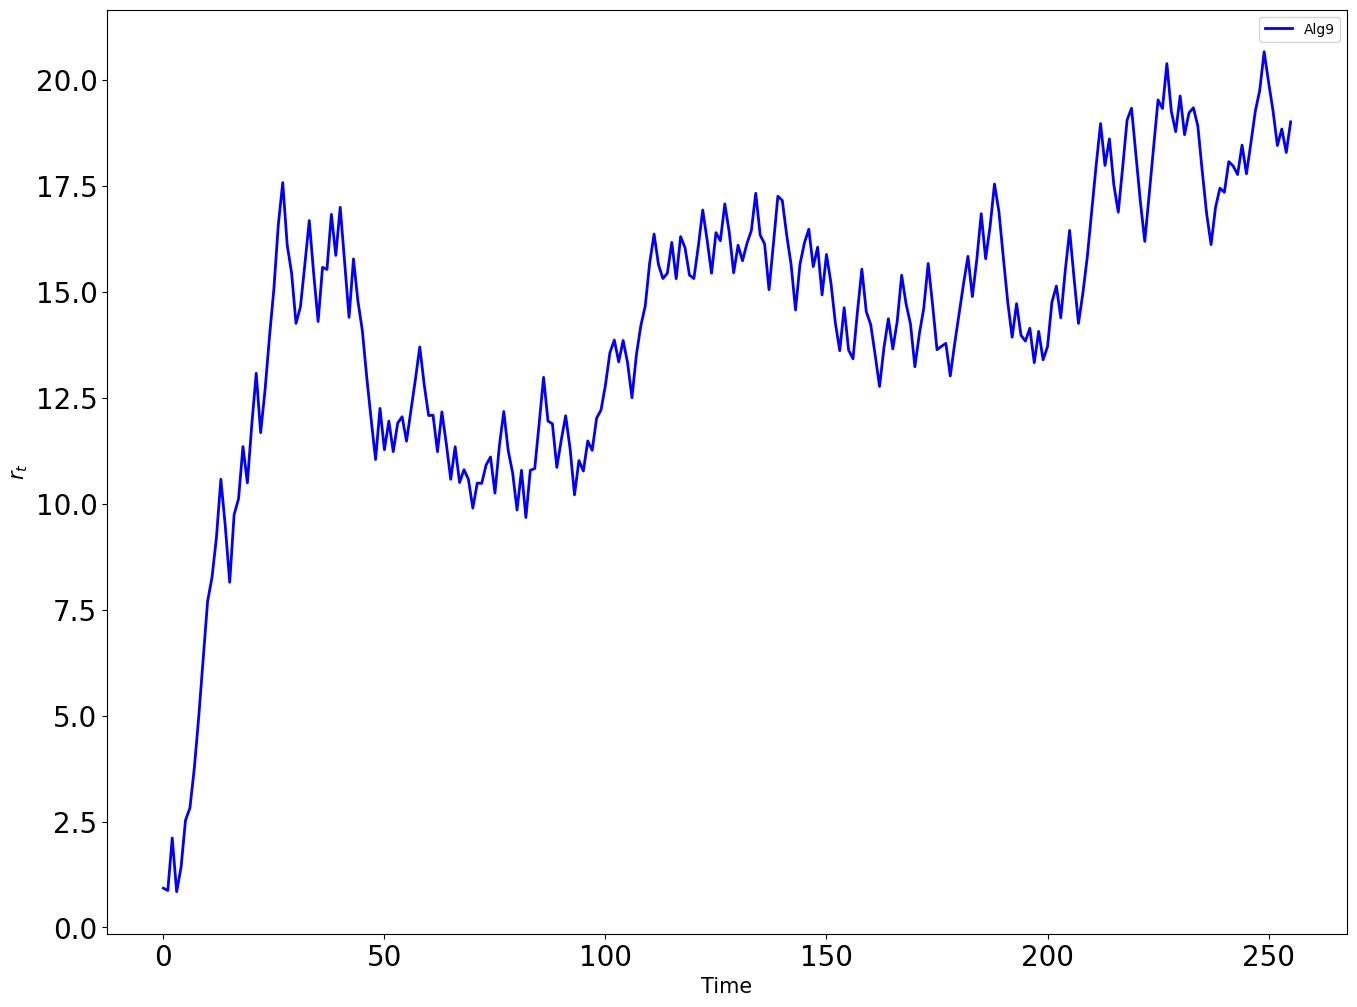

In [213]:
xt = range(T)
plt.figure(figsize= (16,12))
plt.plot(xt,Rt_9_1,'b-',label = 'Alg9',linewidth=2, markersize=7)
plt.xlabel('Time',fontsize = 15)
plt.ylabel(r'$r_t$',fontsize = 15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.show

### Calculate St

In [14]:
def subcalSt(n):
    if n == 1:
        count = 0
    else:
        count = 1
        
    if int(n/2) !=1 and int(n/2) !=0:
        if int(n/2)%2 ==0:
            count = 0
            return subcalSt(int(n/2))
        else:
            count = 1
            count += subcalSt(int(n/2))
    return count


def calSt(n):
    return subcalSt(n) + n%2

In [40]:
calSt(67)

3

In [15]:
def ARSampling_9(M,epsi,d,n,T):
    xt = np.zeros(d)
    cov = M*2*np.log2(T)/epsi
    BurnSize = 10000
    samples = []
    for i in range(BurnSize+n):
        xt_candidate = np.random.multivariate_normal(xt,cov)
        prob_accept = MHNFunc_9(xt_candidate,M,epsi,d,T)/MHNFunc_9(xt,M,epsi,d,T)
        if np.random.uniform(0,1) <min(prob_accept,1):
            xt = xt_candidate
        samples.append(xt)
    return np.asarray(samples[BurnSize:])

    
def MHNFunc_test(x,X,k,M,epsi,d):
    X[k]=x
    if d ==1 :
        lamd = (2/epsi)*M*np.pi**(d/2)/(math.gamma(d/2+1))
    else:
        lamd = np.sqrt(np.linalg.det((2/epsi)*M))*np.pi**(d/2)/(math.gamma(d/2+1))
    return np.exp((-epsi/2)*np.sqrt(HNorm(np.asarray(X),np.linalg.inv(M))[0]))/(math.gamma(d+1)*lamd)

def MHNFunc_9(x,M,epsi,d,T):
    if d ==1 :
        lamd = (2*np.log2(T)/epsi)*M*np.pi**(d/2)/(math.gamma(d/2+1))
    else:
        lamd = np.sqrt(np.linalg.det((2*np.log2(T)/epsi)*M))*np.pi**(d/2)/(math.gamma(d/2+1))
    return np.exp((-epsi/(2*np.log2(T)))*np.sqrt(HNorm(np.asarray(x),np.linalg.inv(M))[0]))/(math.gamma(d+1)*lamd)




In [ ]:
if d==2:
    sxt = -2*np.log(np.random.random(n) * (math.gamma(d+1)*lamd))/epsi
    

In [16]:
def Algorithm11(T,M,N,d,U,Gvt,epi=None):
    if epi==None:
        epi = 1/np.sqrt(T)
    ita = np.sqrt(d/T)
    err = 1e-10

    X = np.zeros((T,M,N))
    X[0] = np.ones((M,N))/N
    Lt = np.zeros((T,N))
    Rtj = np.zeros((T,M))
    Rt = np.zeros(T)

    #np.random.seed(20230321)
    V = np.zeros((M,T,d))
    MU = MVEE(U)
    nLap = ARSampling_9(MU,epi,d,M*T,T)
    nLap = nLap.reshape(T,M,d)
    n_len = int(np.log2(T))
    epsi_t = ARSampling_9(MU,epi,d,n_len*M,T)
    epsi_t = epsi_t.reshape(M,n_len,d)

    for t in range(T):
        vt = Gvt[t]
        Lt[t] = calLt(U,vt)
        #print(Lt[t])

        for j in range(M):
            sumXL = 0
            for k in range(t+1):
                #print(X[k][j])
                sumXL += np.dot(X[k][j],Lt[k].reshape(1,N).T)
                #print(sumXL)
            if t==0:
                Rtj[t][j] = sumXL - min(Lt[t])
                #print(min(Lt[t]))
            else:
                Rtj[t][j] = sumXL - min(sum(Lt[:t+1]))
                #print(min(sum(Lt[0:t+1])))
        #print(Rtj[t])
        Rt[t] = sum(Rtj[t])/M

        H = np.eye(N)+np.dot(np.dot(U,MU),U.T)
        if t<T-1:
            TVt = sum(vt[:t+1])
            st = calSt(t)
            for iz in range(M):    
                V[iz][t] = sum(epsi_t[iz][:st]) + TVt + sum(nLap[t][:n_len-st])
                #print(gtj)
                #print(X[iz])
            #for iz in range(M):
                X[t+1][iz] = _argmin_11(V[iz],N,ita,H,U)
                #print(X[t+1][iz])
        else:
            break
        #print('\n')
    return Rt


In [127]:
MU = MVEE(U)
epsi_t = ARSampling_9(MU,1,d,M*T,T)
np.eye(MU)

TypeError: only integer scalar arrays can be converted to a scalar index

In [151]:
epsi_t = np.random.laplace(0,1,size= (3,2))

In [152]:
epsi_t

array([[-0.04299334, -0.6265583 ],
       [-0.60386211,  0.38846627],
       [-0.24941677,  1.28329972]])

In [153]:
sum(epsi_t)

array([-0.89627221,  1.04520769])

In [95]:
T = 2**8
M = 10
N = 10
d = 3
U = np.zeros((N,d))

while np.linalg.matrix_rank(U) !=d:
    for iN in range(N):
        U[iN] = np.random.uniform(-1,1,d)
Gvt = np.random.uniform(-1,1,(T,d))
Rt_11 = Algorithm11(T,M,N,d,U,Gvt)

In [96]:
Rt_9 = Algorithm9(T,M,N,d,U,Gvt)

In [41]:
np.dot(np.array([0,1,0,0,0]),np.array([1,0.114,0.402,-0.754,-0.388]).reshape(1,N).T) + np.dot(np.array([0,1,0,0,0]),np.array([0.915,0.219,-0.081,-1,-0.844]).reshape(1,N).T)

array([0.333])

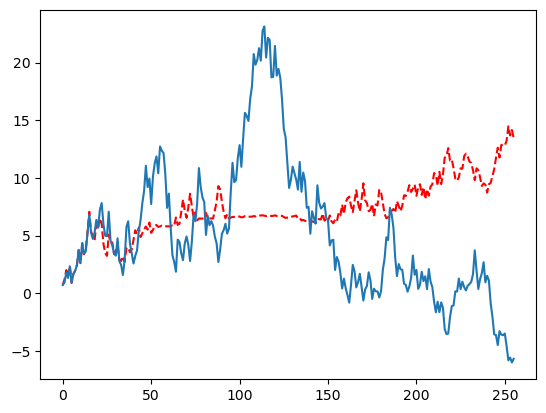

In [97]:
plt.plot(Rt_9,'r--')
plt.plot(Rt_11)

In [173]:
MU = MVEE(U)
n_len = int(np.log2(T))
epsi_t = ARSampling_9(MU,1,d,n_len*M,T)
#epsi_t = epsi_t.reshape(M,n_len,d)

In [177]:
epsi_t

array([[  0.58658205,  20.96805853],
       [ -9.64898902,  20.6683488 ],
       [-13.48231576,  23.91790486],
       [-15.46780118,  26.03646462],
       [ -6.4776923 ,  19.78178281],
       [-11.95751791,  38.16738324],
       [-17.46787195,  36.41495782],
       [-17.07423198,  40.63327293],
       [ -9.16939203,  44.58247172],
       [-17.90081358,  44.69740402],
       [-23.16495721,  42.62801855],
       [-14.17383076,  29.2082781 ],
       [-13.64895282,  25.65954825],
       [ -4.7985243 ,  37.0806349 ],
       [ -0.4823207 ,  35.9739133 ],
       [ -4.50074854,  25.70983388],
       [ 13.02913418,  29.84482211],
       [ 12.86384253,  23.40306044],
       [  4.68112566,  20.98112234],
       [ 11.52254052,  31.26849527],
       [ 11.97376815,  30.42353637],
       [ 11.97376815,  30.42353637],
       [ 21.28913666,  36.82621681],
       [ 30.04137306,  28.99440717],
       [ 23.23136044,  34.39329674],
       [ 23.53494151,  35.24648086],
       [ 23.53494151,  35.24648086],
 

In [176]:
epsi_t.reshape(M,n_len,d)

array([[[  0.58658205,  20.96805853],
        [ -9.64898902,  20.6683488 ],
        [-13.48231576,  23.91790486],
        [-15.46780118,  26.03646462],
        [ -6.4776923 ,  19.78178281],
        [-11.95751791,  38.16738324],
        [-17.46787195,  36.41495782],
        [-17.07423198,  40.63327293],
        [ -9.16939203,  44.58247172]],

       [[-17.90081358,  44.69740402],
        [-23.16495721,  42.62801855],
        [-14.17383076,  29.2082781 ],
        [-13.64895282,  25.65954825],
        [ -4.7985243 ,  37.0806349 ],
        [ -0.4823207 ,  35.9739133 ],
        [ -4.50074854,  25.70983388],
        [ 13.02913418,  29.84482211],
        [ 12.86384253,  23.40306044]],

       [[  4.68112566,  20.98112234],
        [ 11.52254052,  31.26849527],
        [ 11.97376815,  30.42353637],
        [ 11.97376815,  30.42353637],
        [ 21.28913666,  36.82621681],
        [ 30.04137306,  28.99440717],
        [ 23.23136044,  34.39329674],
        [ 23.53494151,  35.24648086],
        

In [122]:
A[1][:2]

array([[1., 1., 1., 1., 1.],
       [1., 3., 1., 1., 1.]])

In [62]:
calSt(11)

3

In [24]:
int(12/2)%2

0

In [120]:
E = np.asarray([[2,-1],[-1,2]])
X = np.random.random(size = 2)
1/np.linalg.inv(E)

array([[1.5, 3. ],
       [3. , 1.5]])

In [27]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import math

def _minf(g, ita):
    g = np.asarray(g)
    err = 1e-10
    n = g.shape[0]
    m = gp.Model('minf')
    k = m.addVars(n, lb=0.0, ub=GRB.INFINITY)
    m.setObjective(sum(g[i]*k[i] for i in range(n)) + (1/ita)*sum(k[i]*math.log(k[i]+err) for i in range(n)), GRB.MINIMIZE)
    m.optimize()
    if m.status == GRB.OPTIMAL:
        return np.array([k[i].x for i in range(n)])
    else:
        raise ValueError('Gurobi failed to solve the optimization problem.')




In [28]:
g = np.random.rand(100)
ita = 0.5
_minf(g,ita)

TypeError: must be real number, not gurobipy.LinExpr

In [34]:
import gurobipy as gp
import numpy as np

# Define the data
n = 100
g = np.random.rand(n)

# Define the model
m = gp.Model('linear_programming')
x = m.addVars(n, lb=0, name='x')

# Set the objective function
err = 1e-10
v = gp.quicksum(g[i] * x[i] for i in range(n)) + gp.quicksum((1 / ita) * x[i] * math.log(x[i] + err) for i in range(n))
m.setObjective(v, gp.GRB.MINIMIZE)

# Set the constraints
m.addConstr(gp.quicksum(x[i] for i in range(n)) == 1)
m.addConstrs(x[i] <= 1 for i in range(n))

# Solve the model
m.optimize()

# Print the results
print('Objective value: ', m.ObjVal)
print('Solution: ', [x[i].x for i in range(n)])


TypeError: must be real number, not gurobipy.LinExpr

In [101]:
import numpy as np
import math

def MHNFunc(x, M, epsi, d):
    if d == 1:
        lamd = (2/epsi) * M * np.pi**(d/2) / math.gamma(d/2+1)
    else:
        lamd = np.sqrt(np.linalg.det((2/epsi)*M)) * np.pi**(d/2) / math.gamma(d/2+1)
    return np.exp((-epsi/2) * np.sqrt(HNorm(x, np.linalg.inv(M)))) / (math.gamma(d+1) * lamd)

def HNorm(vec, H):
    d = len(vec)
    return np.dot(np.dot(vec, H), vec.reshape(d, 1))

def metropolis_hastings(p, qdraw, nsamp, xinit):
    samples = np.zeros((nsamp, len(xinit)))
    xprev = xinit
    accepted = 0
    for i in range(nsamp):
        xstar = qdraw(xprev)
        pstar = p(xstar)
        pprev = p(xprev)
        if np.random.uniform() < min(pstar / pprev,1):
            xprev = xstar
            accepted += 1
        samples[i] = xprev
    return samples, accepted / nsamp

# define the MHNFunc distribution parameters
M = np.array([[1, 0.5], [0.5, 2]])
epsi = 1
d = 2

# define the proposal distribution
def qdraw(xprev):
    return np.random.multivariate_normal(xprev, M)

# define the number of samples to generate and the initial value
nsamp = 10000
xinit = np.array([0, 0])

# run the Metropolis-Hastings algorithm
samples, acceptance_rate = metropolis_hastings(lambda x: MHNFunc(x, M, epsi, d), qdraw, nsamp, xinit)

# print the acceptance rate and the mean of the generated samples
print("Acceptance rate:", acceptance_rate)
print("Mean of the generated samples:", np.mean(samples, axis=0))


Acceptance rate: 0.8102
Mean of the generated samples: [-0.2138811  -0.17265575]


(array([0.00071625, 0.00153129, 0.00654501, 0.02235184, 0.05937439,
        0.0889381 , 0.04697591, 0.01654777, 0.00313667, 0.00086444]),
 array([-21.7680194 , -17.71913576, -13.67025212,  -9.62136849,
         -5.57248485,  -1.52360121,   2.52528242,   6.57416606,
         10.6230497 ,  14.67193333,  18.72081697]),
 <BarContainer object of 10 artists>)

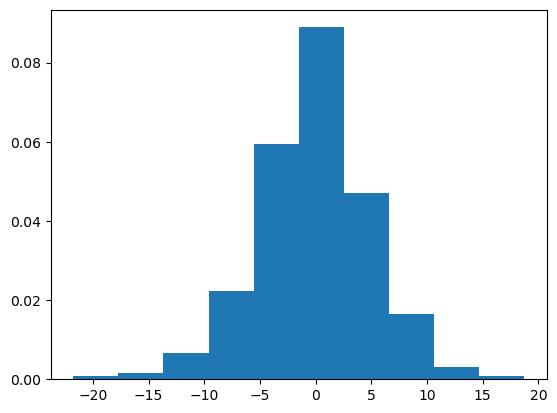

In [103]:
plt.hist(samples.T[1],density=True)

二叉树求和
T>N>d

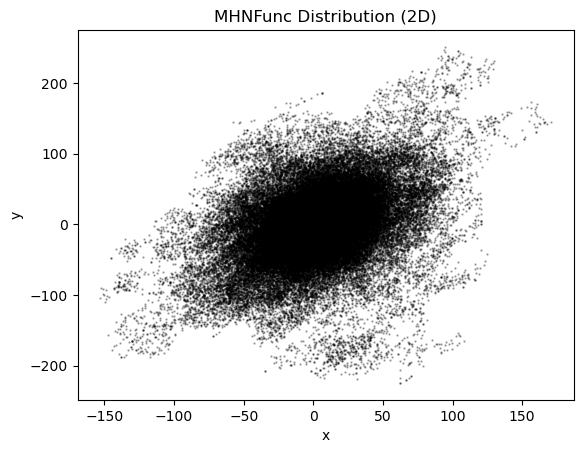

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.neighbors import KernelDensity

def MHNFunc(x, M, epsi, d):
    if d == 1:
        lamd = (2 / epsi) * M * np.pi**(d / 2) / (np.math.gamma(d / 2 + 1))
    else:
        lamd = np.sqrt(np.linalg.det((2 / epsi) * M)) * np.pi**(d / 2) / (np.math.gamma(d / 2 + 1))
    return np.exp((-epsi / 2) * np.sqrt(HNorm(np.asarray(x), np.linalg.inv(M))[0])) / (np.math.gamma(d + 1) * lamd)

def ARSampling(M, epsi, d, n):
    xt = np.zeros(d)
    cov = M * 2 / epsi
    BurnSize = 10000
    samples = []
    for i in range(BurnSize + n):
        xt_candidate = np.random.multivariate_normal(xt, cov)
        prob_accept = min(MHNFunc(xt_candidate, M, epsi, d) / MHNFunc(xt, M, epsi, d), 1)
        if np.random.uniform(0, 1) < prob_accept:
            xt = xt_candidate
        samples.append(xt)
    return np.asarray(samples[BurnSize:])

# Define distribution parameters
M = np.array([[1, 0.5], [0.5, 2]])
epsi = 0.1
d = 2
n = 100000

# Generate samples
samples = ARSampling(M, epsi, d, n)

# KDE plot
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(samples)
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
xy = np.column_stack([X.ravel(), Y.ravel()])
Z = np.exp(kde.score_samples(xy)).reshape(X.shape)
plt.contourf(X, Y, Z, levels=20, cmap='cool')
plt.scatter(samples[:, 0], samples[:, 1], s=0.5, alpha=0.3, color='black')
plt.title("MHNFunc Distribution (2D)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


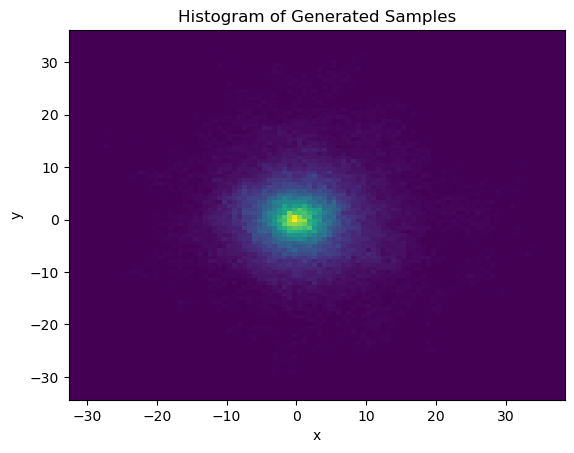

In [106]:
import numpy as np
import matplotlib.pyplot as plt

def mcmc_sampler(p, q_sampler, n_samples, x_init):
    """
    Generate random samples from the distribution p using Metropolis-Hastings algorithm.

    Parameters:
        p: function
            The target distribution from which we want to generate random samples.
        q_sampler: function
            A function that takes in the current state and returns a new state sampled from the proposal distribution.
        n_samples: int
            The number of samples to generate.
        x_init: numpy.ndarray
            The initial state.

    Returns:
        numpy.ndarray
            An array of size n_samples x d, where d is the dimensionality of the target distribution p.
    """
    d = len(x_init)
    x = np.zeros((n_samples, d))
    x[0] = x_init
    for i in range(1, n_samples):
        x_star = q_sampler(x[i-1])
        acceptance_prob = min(1, p(x_star) / p(x[i-1]))
        if np.random.uniform(0, 1) < acceptance_prob:
            x[i] = x_star
        else:
            x[i] = x[i-1]
    return x

# define the target distribution we want to sample from
def MHNFunc(x, M, epsi, d):
    if d == 1:
        lamd = (2/epsi) * M * np.pi**(d/2) / math.gamma(d/2+1)
    else:
        lamd = np.sqrt(np.linalg.det((2/epsi) * M)) * np.pi**(d/2) / math.gamma(d/2+1)
    return np.exp((-epsi/2) * np.sqrt(HNorm(np.asarray(x), np.linalg.inv(M))[0])) / (math.gamma(d+1) * lamd)

# define the proposal distribution
def q_sampler(x):
    return np.random.multivariate_normal(x, np.identity(d))

# set the parameters
d = 2
M = np.identity(d)
epsi = 0.5
x_init = np.zeros(d)
n_samples = 100000

# generate random samples using Metropolis-Hastings algorithm
samples = mcmc_sampler(lambda x: MHNFunc(x, M, epsi, d), q_sampler, n_samples, x_init)

# plot histogram of generated samples
plt.hist2d(samples[:, 0], samples[:, 1], bins=100, density=True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Histogram of Generated Samples')
plt.show()


In [109]:
a = np.array([[1,3,4],[2,36,1]])
b = a.copy()
b.sort()

b

array([[ 1,  3,  4],
       [ 1,  2, 36]])

In [39]:
lt = np.array([[0.5,1,0.5],[0,0,1],[1,0,0]])
lt

array([[0.5, 1. , 0.5],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ]])

In [112]:
np.random.uniform(-1,1,size=(5,2))

array([[-0.95152518,  0.28603487],
       [ 0.89114478, -0.32792918],
       [-0.49564236,  0.77238757],
       [ 0.28582072, -0.63615528],
       [ 0.31935025, -0.61951877]])